# Project 1

For your first project you are going to go through each of the following functions and optimize in terms of memory and speed. You can import any libraries and perform any code transformations but the end result must be equal in order to be correct.

I recommend that you create a separate notebook or open an IDE and experiment there. Then come back to this notebook and write your answer. Each function has a cell with the original function, another one for your solution, and a profiling and correctness checker. The final submission will be this notebook plus a consecutive run in your PC (restart, run all and save as html) and another run on your Jetson Nano. You will submit all three files on Canvas.

The first cell is used to import the libraries we need to run these functions, the second cell will be for your libraries

In [10]:
import numpy as np
import ctypes
import math
import time
from scipy import misc,ndimage
import matplotlib.pyplot as plt
from PIL import Image
%pip install numpy==2.1
from numba import jit,prange
import requests
from io import BytesIO
%pip install opencv-python
%pip install memory_profiler
import cv2
%load_ext memory_profiler


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [11]:
#### Import your libraries here


In [12]:
url1="http://getwallpapers.com/wallpaper/full/c/a/7/1235918-3000-x-3000-hd-wallpapers-3000x2000-for-hd-1080p.jpg"
url2="http://getwallpapers.com/wallpaper/full/c/4/1/1235927-3000-x-3000-hd-wallpapers-3000x2000-screen.jpg"
response1 = requests.get(url1)
response2 = requests.get(url2)

### These will be used as input arrays, they are all images transformed to numpy arrays
#A = Image.open('nature.jpg')
# convert image to numpy array
A = Image.open(BytesIO(response1.content))
A = np.asarray(A)/255
A = np.mean(A, axis=2)*255

#B = Image.open('sun.jpg')
# convert image to numpy array
B = Image.open(BytesIO(response2.content))
B = np.asarray(B)/255
B = np.mean(B, axis=2)*255
C=np.random.rand(A.shape[0],A.shape[1])*255




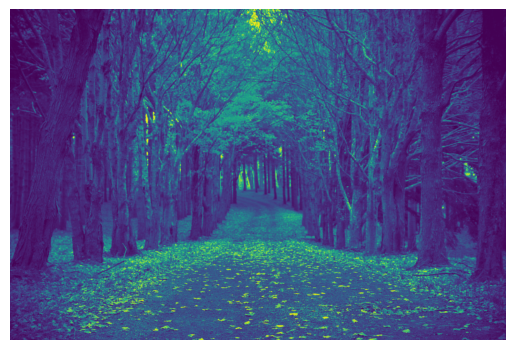

In [13]:
### Verify the images are there and they are grayscale

plt.axis('off')
plt.imshow(A)
plt.show()

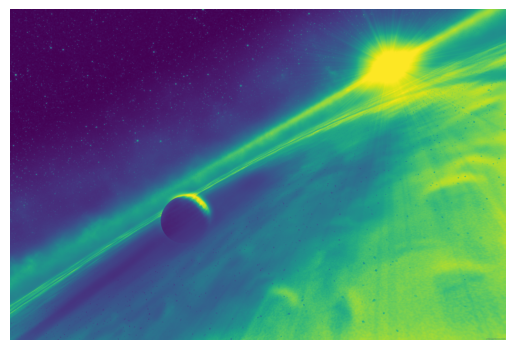

In [14]:
plt.axis('off')
plt.imshow(B)
plt.show()

## Loop 1

In [15]:
def loop1(A,B):
    a=np.copy(A)
    b=np.copy(B)

    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j,i] = a[j - 1,i] + b[j,i];
            b[j,i] = b[j,i]**2
        
    return a,b
    
        
        


In [16]:
x,y=loop1(A,B)

In [17]:
%%timeit
loop1(A,B)

2.99 s ± 49.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%memit loop1(A,B)

peak memory: 1251.80 MiB, increment: 0.20 MiB


In [19]:
## just using numba here
@jit(nopython=True)
def loop1_sol1(A,B):
    a=np.copy(A)
    b=np.copy(B)

    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j,i] = a[j - 1,i] + b[j,i];
            b[j,i] = b[j,i]**2

#     for j in range (1, a.shape[0]-1):
#             a[j,1:-1] = a[j - 1,1:-1] + b[j,1:-1]
#     b[1:-1, 1:-1] = b[1:-1, 1:-1]**2
        
    return a,b

In [20]:
x1,y1=loop1_sol1(A,B)

In [21]:
%%timeit
loop1_sol1(A,B)

14.8 ms ± 158 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%memit loop1_sol1(A,B)

peak memory: 1283.38 MiB, increment: 0.00 MiB


In [23]:
# ## custom here
# # @jit(nopython=True)
def loop1_sol2(A,B):
  a=np.copy(A)
  b=np.copy(B)

#     for j in range (1,a.shape[0]-1):
#         for i in range (1,a.shape[1]-1):
#             a[j,i] = a[j - 1,i] + b[j,i];
#             b[j,i] = b[j,i]**2

  for j in range (1, a.shape[0]-1):
          a[j,1:-1] = a[j - 1,1:-1] + b[j,1:-1]
          b[j,1:-1] = b[j, 1:-1]**2
  
        
  return a,b

In [24]:
x2,y2=loop1_sol2(A,B)

In [25]:
%%timeit
loop1_sol2(A,B)

18.9 ms ± 265 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%memit loop1_sol2(A,B)

peak memory: 1372.36 MiB, increment: 0.00 MiB


In [27]:
##### If output is false, then your solution is incorrect

print(np.allclose(x,x1))
print(np.allclose(y,y1))
print(np.allclose(x,x2))
print(np.allclose(y,y2))



True
True
True
True


I cant manage to make custom code faster than numba, but thats proabbly do to granularity of detail available, im close with 16ms(numba) vs 19ms(me) vs 3000ms(default)

In [28]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,y,x1,y1,x2,y2

## Loop 2

In [29]:
def loop2(A, B, C):
    a=np.copy(A)
    b=np.copy(B)


    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j][i] = a[j-1][i] + C[j][i]
        for i in range (1,b.shape[1]-1):
            b[j][i] = b[j][i-1] + C[j][i]

        
    return a, b

In [30]:
x,y = loop2(A,B,C)

In [31]:
%%timeit
loop2(A,B,C)

5.03 s ± 86.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%memit loop2(A,B,C)

peak memory: 1215.00 MiB, increment: 0.00 MiB


In [33]:
@jit(nopython=True)
def loop2_sol1(A, B, C):
    a=np.copy(A)
    b=np.copy(B)


    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j][i] = a[j-1][i] + C[j][i]
        for i in range (1,b.shape[1]-1):
            b[j][i] = b[j][i-1] + C[j][i]
    

        
    return a, b

In [34]:
x1,y1=loop2_sol1(A,B,C)

In [35]:
%%timeit
loop2_sol1(A,B,C)

19.7 ms ± 283 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%memit loop2_sol1(A,B,C)

peak memory: 1180.28 MiB, increment: 0.00 MiB


In [37]:
def loop2_sol2(A, B, C):
    a=np.copy(A)
    b=np.copy(B)


    # for j in range (1,a.shape[0]-1):
    #     for i in range (1,a.shape[1]-1):
    #         a[j][i] = a[j-1][i] + C[j][i]
    #     for i in range (1,b.shape[1]-1):
    #         b[j][i] = b[j][i-1] + C[j][i] 
    m = a.shape[0]-1
    n = a.shape[1]-1
    for j in range(1, a.shape[0]-1):
        a[j, 1:n] = a[j-1, 1:n] + C[j, 1:n]
    for i in range (1, b.shape[1]-1):
        b[1:m,i] = b[1:m, i-1] + C[1:m, i]

    
    
    return a, b

In [38]:
x2,y2=loop2_sol2(A,B,C)

In [39]:
%%timeit
loop2_sol2(A,B,C)

68.5 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%memit loop2_sol2(A,B,C)

peak memory: 1180.28 MiB, increment: 0.00 MiB


In [41]:
##### If output is false, then your solution is incorrect
print(np.allclose(x,x1))
print(np.allclose(y,y1))
print(np.allclose(x,x2))
print(np.allclose(y,y2))

True
True
True
True


In [42]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,y,x1,y1,x2,y2

## Matrix multiplication

In [43]:

# SGEMM Form => C := alpha*A*B + beta*C,
# We create new variable because the images are too big
Am=np.random.rand(100,500)
Bm=np.random.rand(500,250)
Dm=np.random.rand(100,250)
# alpha and beta are constant floating point values, reuse them for your solution
alpha = 1.5
beta = 1.2 

def sgemm_manual (alpha,A, B, beta, D):

    d=np.copy(D)
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            d[i,j] *= beta
        for k in range(A.shape[1]):
            for j in range(d.shape[1]):
                d[i,j] += alpha * A[i,k] * B[k,j]
    return d            


In [44]:
x=sgemm_manual (alpha,Am, Bm, beta, Dm) 

In [45]:
%%timeit
sgemm_manual (alpha,Am, Bm, beta, Dm)  

4.8 s ± 82.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:

%mprun sgemm_manual (alpha,Am, Bm, beta, Dm) 

In [47]:
@jit(nopython=True)
def sgemm_solution (alpha,A, B, beta, D):
    d=np.copy(D)
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            d[i,j] *= beta
        for k in range(A.shape[1]):
            for j in range(d.shape[1]):
                d[i,j] += alpha * A[i,k] * B[k,j]
    return d  

In [48]:
x1=sgemm_solution (alpha,Am, Bm, beta, Dm)

In [49]:
%%timeit
sgemm_solution (alpha,Am, Bm, beta, Dm)

2.62 ms ± 62.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
%memit sgemm_solution (alpha,Am, Bm, beta, Dm)

peak memory: 1089.84 MiB, increment: 0.00 MiB


In [51]:
def sgemm_solution2 (alpha,A, B, beta, D):
    d=np.copy(D)
    #for i in range(d.shape[0]):
        # for j in range(d.shape[1]):
        #     d[i,j] *= beta
        # for k in range(A.shape[1]):
        #     for j in range(d.shape[1]):
        #         d[i,j] += alpha * A[i,k] * B[k,j]
    # d = beta * d + alpha * np.dot(A,B)
    m, n = d.shape
    o = A.shape[1]
            
    for i in range(m):
        d[i,:n] *=beta
        # for k in range(A.shape[1]):
        d[i:n] += alpha * np.dot(A[i,:], B)
        #     d[i,:n] += alpha * A[i,k] * B[k,:n]
    return d  

In [52]:
x1=sgemm_solution2(alpha,Am, Bm, beta, Dm)

In [53]:
%%timeit
sgemm_solution2 (alpha,Am, Bm, beta, Dm)

3.91 ms ± 393 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
%memit sgemm_solution2 (alpha,Am, Bm, beta, Dm)

peak memory: 1091.16 MiB, increment: 0.00 MiB


In [55]:
def optimizedsgemm(alpha, A, B, beta, d):
    m, n = d.shape  
    o = A.shape[1]  # The number of columns in A (also the number of rows in B)
    
    # Multiply each row of d by beta (this can be done directly)
    d[:, :n] *= beta
    
    # Perform the matrix operation
    d[:, :n] += alpha * (A @ B[:, :n])  # Matrix multiplication
    
    return d

In [56]:
x2=optimizedsgemm (alpha,Am, Bm, beta, Dm)

In [57]:
%%timeit
optimizedsgemm (alpha,Am, Bm, beta, Dm)

/var/folders/9f/6d2xdp5d6rs98prwd26zsk200000gn/T/ipykernel_79120/4227642191.py:6: RuntimeWarning: overflow encountered in multiply
  d[:, :n] *= beta


129 μs ± 4.32 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [58]:
##### If output is false, then your solution is incorrect
print(np.allclose(x,x1))
print(np.allclose(x,x2))

False
False


In [59]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,x1, x2

## Laplacian operator

In [60]:
def Laplacian_Operator(A):
    x = A.shape[0]
    y = A.shape[1]
    laplacian = np.empty((x - 2, y - 2))
    for i in range(1, x - 1):
        for j in range(1, y - 1):
            laplacian[i-1, j-1] = np.abs(A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1] - 4*A[i, j]) > 0.05
    return laplacian


In [61]:
LO=Laplacian_Operator(A)

In [62]:
%%timeit
Laplacian_Operator(A)


7.92 s ± 77.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%memit Laplacian_Operator(A)

peak memory: 1091.47 MiB, increment: 0.00 MiB


In [64]:
def Laplacian_Operator_Sol(A):
   
    x = A.shape[0]
    y = A.shape[1]
    laplacian = np.empty((x - 2, y - 2))
    # laplacian[0:x-2, 0:y-2] = np.abs(A[0:x-2, 1:y-1] + A[2:x, 1:y-1] + A[1:x-1, 0:y-2] + A[1:x-1, 2:y] - 4*A[1:x-1, 1:y-1]) > 0.05

    for i in range(1, x - 1):
        laplacian[i-1, 0:y-2] = np.abs(A[i-1, 1:y-1] + A[i+1, 1:y-1] + A[i, 0:y-2] + A[i, 2:y] - 4*A[i, 1:y-1]) > 0.05
        # for j in range(1, y - 1):
        #     laplacian[i-1, j-1] = np.abs(A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1] - 4*A[i, j]) > 0.05
    
    
    return laplacian


In [65]:
@jit(nopython=True)
def Laplacian_Operator_Numba(A):
    x = A.shape[0]
    y = A.shape[1]
    laplacian = np.empty((x - 2, y - 2))
    for i in range(1, x - 1):
        for j in range(1, y - 1):
            laplacian[i-1, j-1] = np.abs(A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1] - 4*A[i, j]) > 0.05
    return laplacian
    
    
    return laplacian


In [66]:
SO=Laplacian_Operator_Sol(A)

In [67]:
NO=Laplacian_Operator_Numba(A)

In [68]:
%%timeit
Laplacian_Operator_Sol(A)

32.4 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
%%timeit
Laplacian_Operator_Numba(A)

8.15 ms ± 110 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
%memit Laplacian_Operator_Sol(A)

peak memory: 601.81 MiB, increment: 0.00 MiB


In [63]:
%memit Laplacian_Operator_Numba(A)

peak memory: 601.81 MiB, increment: 0.00 MiB


In [70]:
##### If output is false, then your solution is incorrect
print(np.allclose(LO,SO))
print(np.allclose(LO,NO))

True
True


In [ ]:
##### Cleanup, get rid of all the objects we don't need anymore
del LO, SO, NO